In [1]:
import sys
sys.path.append('/mnt/c/Users/wayne/tvb/tvbtools/')
from tvbtools.signaltools import SignalToolkit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import scipy
my_layout = widgets.Layout()
plt.style.use('ggplot')
import os
import random


In [2]:
node_names = ['aCNG-L', 'aCNG-R','mCNG-L','mCNG-R','pCNG-L','pCNG-R', 'HIP-L','HIP-R','PHG-L','PHG-R','AMY-L','AMY-R', 'sTEMp-L','sTEMp-R','mTEMp-L','mTEMp-R']
path = '/mnt/c/Users/Wayne/tvb/stat_data/Gc_Go.xlsx'
coData = pd.read_excel(path, index_col=0)

def bold_psd(grp, caseid):
    # import empirical functional connectivity
    # Here is the path of the mat file of the FC data
    pth = "/mnt/c/Users/Wayne/tvb/TS-4-Vik/"+ grp+'-TS/'+ caseid +"/ROISignals_"+ caseid +".mat"
    subject = SignalToolkit(filename=pth, fs=0.5)
    bold = subject.data_reader()
    df = pd.DataFrame.from_dict(bold.get("ROISignals"))
    df.columns = node_names
    dfd = pd.DataFrame()
    # for i in range(16):
    #     x, y = subject.psd(data=df.iloc[:,i], visual=False)
    #     _dfd = pd.Series(data=y,copy=False)
    #     dfd = pd.concat([dfd, _dfd], ignore_index = True, axis=1)
    # dfd.columns = node_names

    # la = (y2[1:int(len(x2)/2)] - y1[1:int(len(x1)/2)])/(y1[1:int(len(x1)/2)] + y2[1:int(len(x2)/2)])
    axes = subject.panel()
    faxis, dominant_left = subject.psd(data=df.iloc[:,4], sampling_interval=2, visual=True, xlim=0.25, axes = axes, fNQ = 512, label="pcg_left")
    faxis, dominant_right = subject.psd(data=df.iloc[:,5], sampling_interval=2, visual=True, xlim=0.25, axes = axes, fNQ = 512, label="pcg_right")
    plt.legend()
    return faxis[np.argmax(dominant_left)]*dominant_left[np.argmax(dominant_left)], faxis[np.argmax(dominant_right)]*dominant_right[np.argmax(dominant_right)]

    
    # dfd.plot.bar(figsize=(15,5))

    # dfd.to_excel(f"/mnt/c/Users/Wayne/tvb/psdres/psd_data/{grp}/{caseid}.xlsx")
    # axes = subject.panel()
    # axes.set_title(f"{grp}_{caseid}_limbic")
    # for i in range(16):
    #     subject.psd(data=df.iloc[:,i], visual=True, axes=axes, xlim=0.25, label =node_names[i], c=colorlist[i])
    # plt.legend()
    # plt.savefig(f"/mnt/c/Users/wayne/tvb/psdres/limbic/{grp}_{caseid}.png", dpi=300)
    
    # axes = subject.panel()
    # axes.set_title(f"{grp}_{caseid}_pcg")
    # for i in [4,5]:
    #     subject.psd(data=df.iloc[:,i], visual=True, axes=axes, xlim=0.25, label =node_names[i], c=colorlist[i])
    # plt.legend()
    # plt.savefig(f"/mnt/c/Users/wayne/tvb/psdres/pcg/{grp}_{caseid}.png", dpi=300)


/mnt/c/Users/wayne/tvb/tvbtools/tvbtools/signaltools.py:242: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


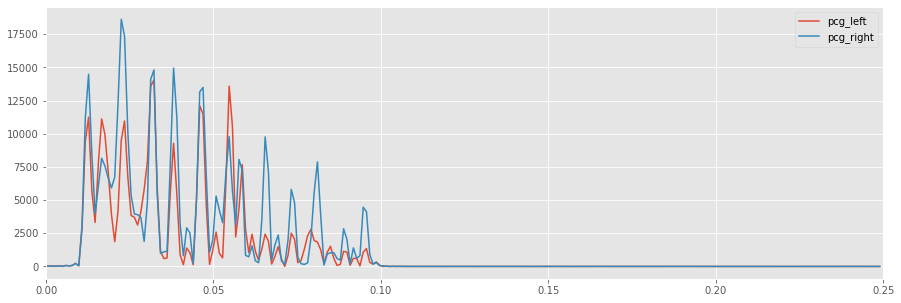

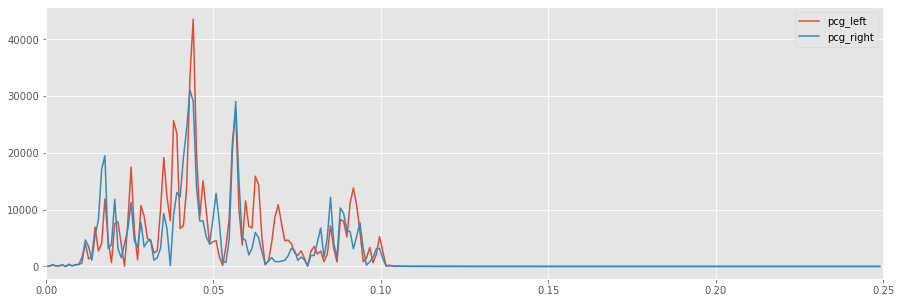

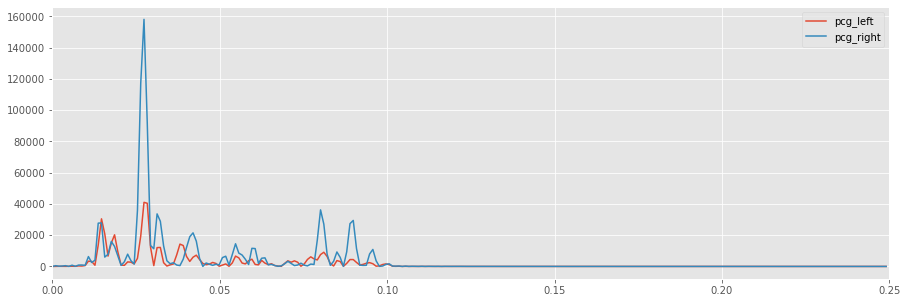

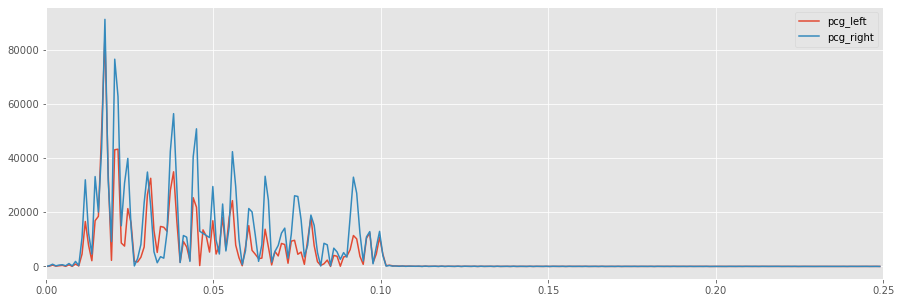

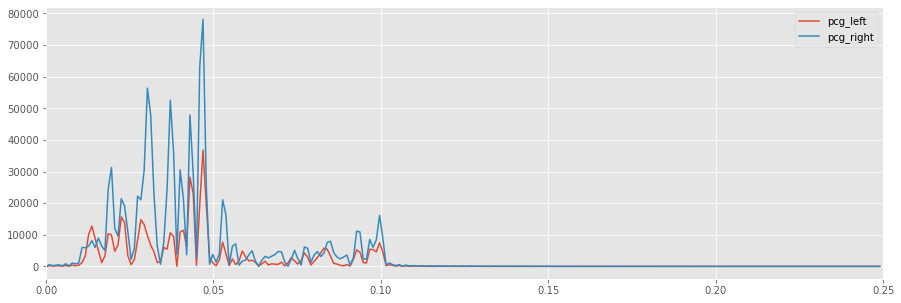

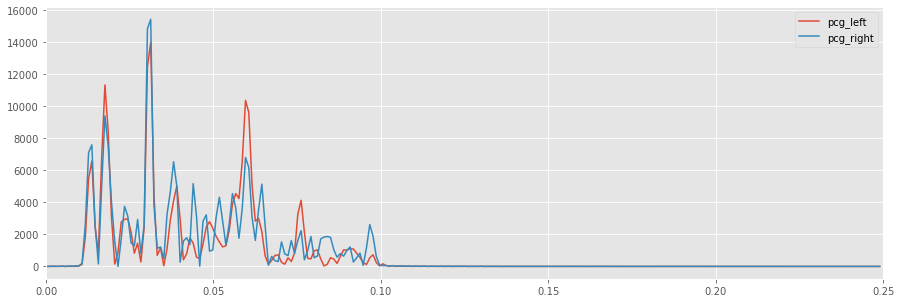

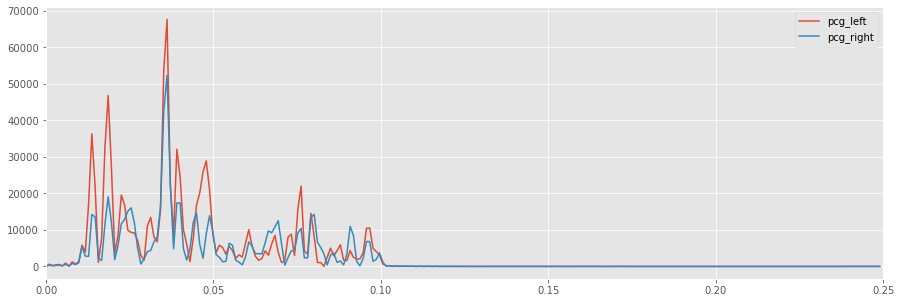

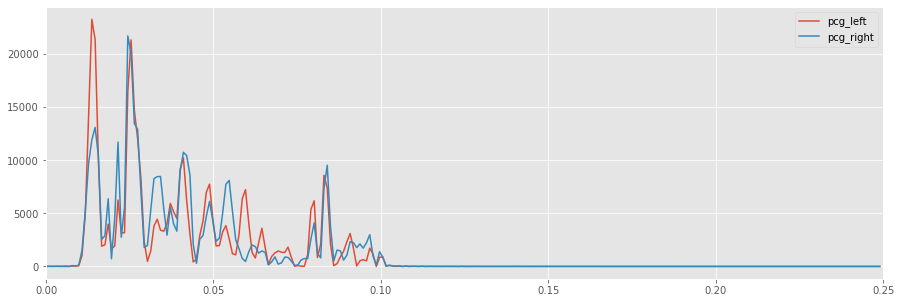

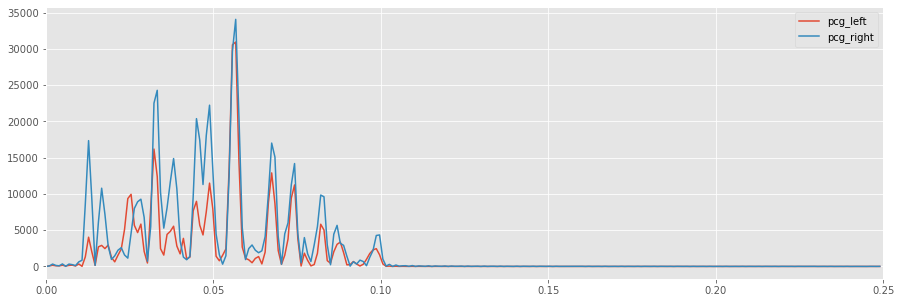

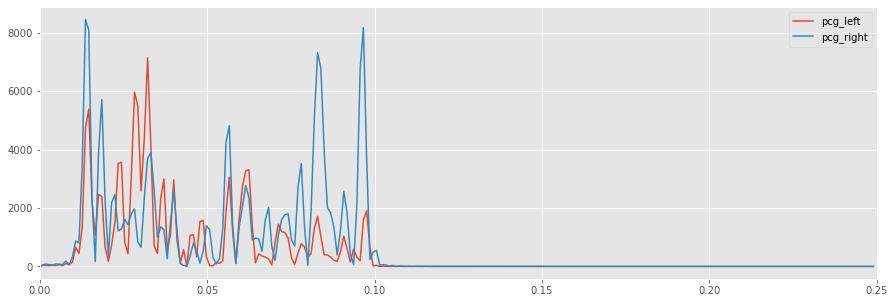

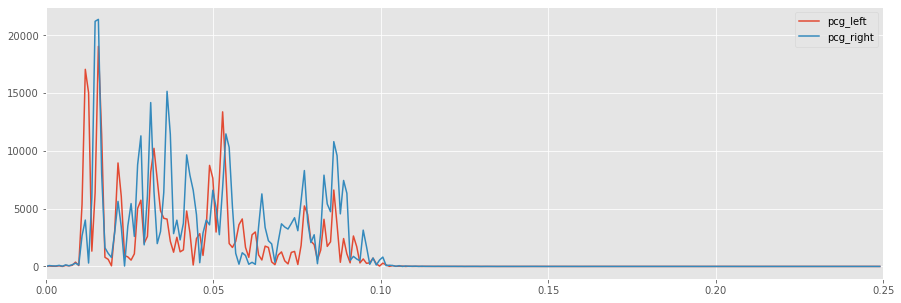

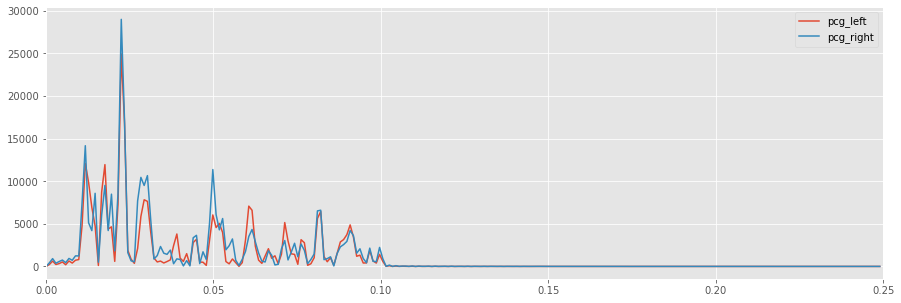

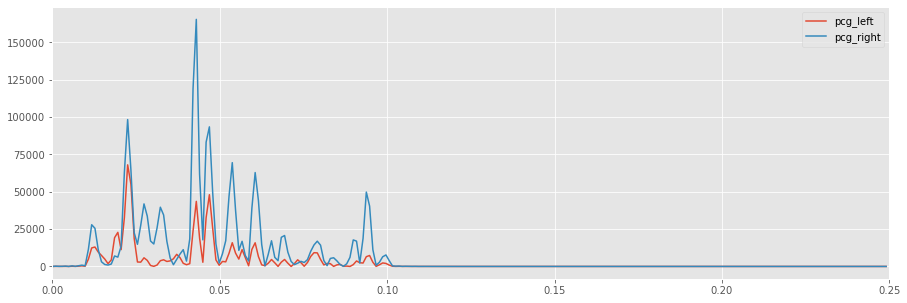

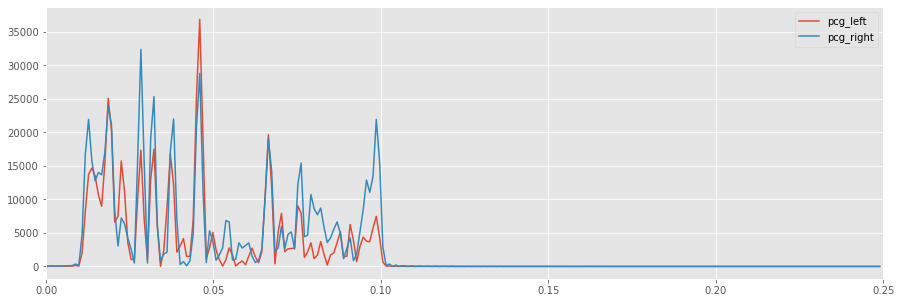

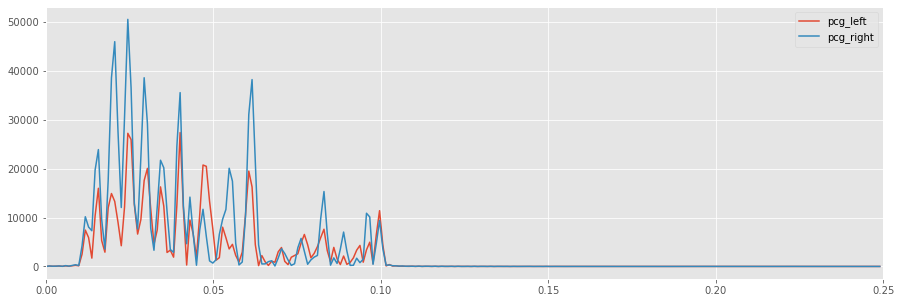

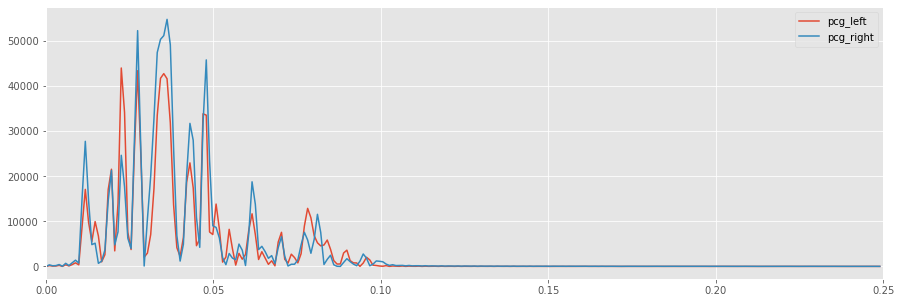

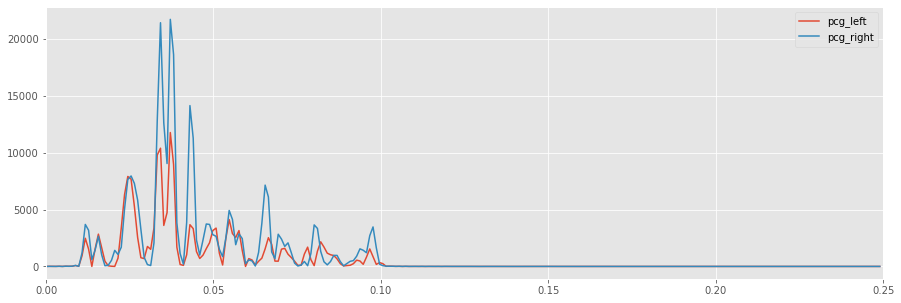

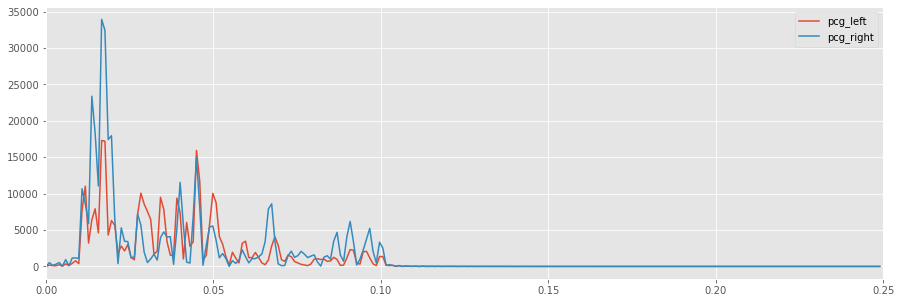

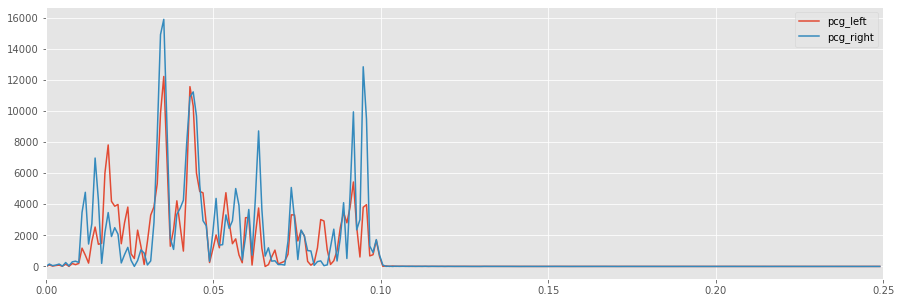

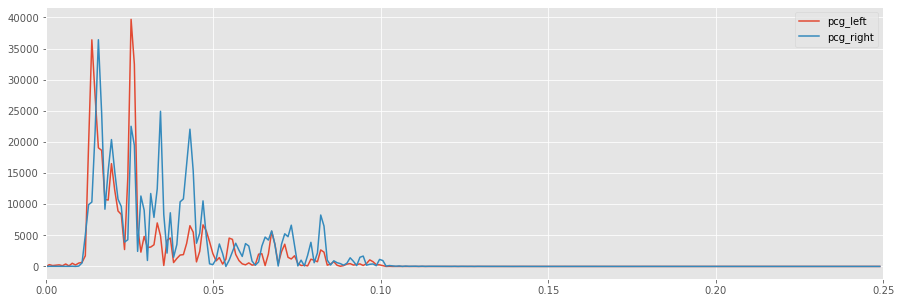

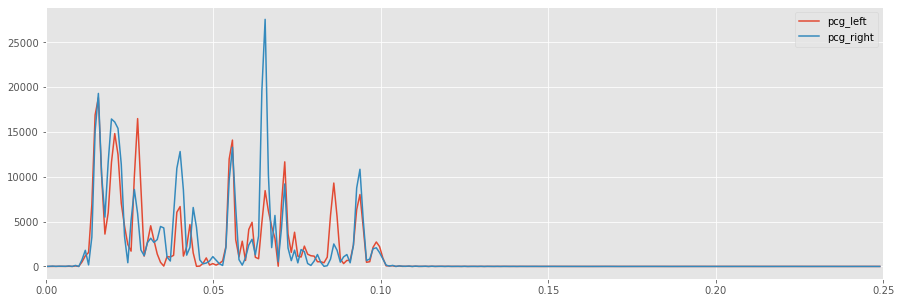

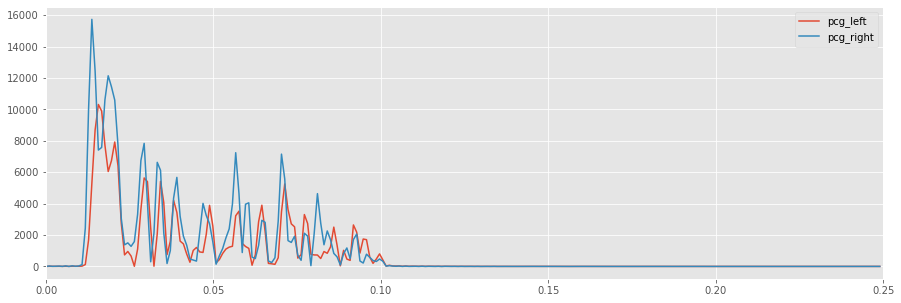

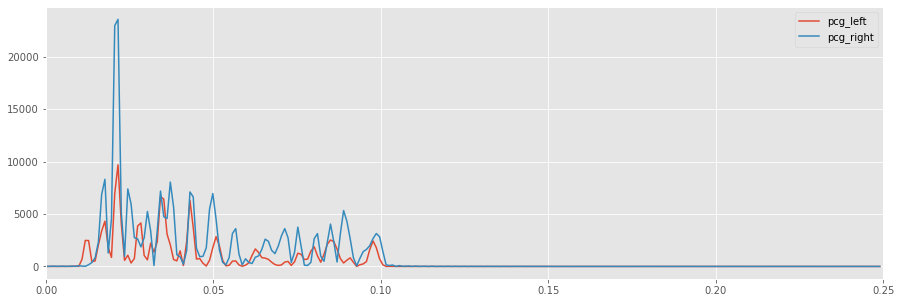

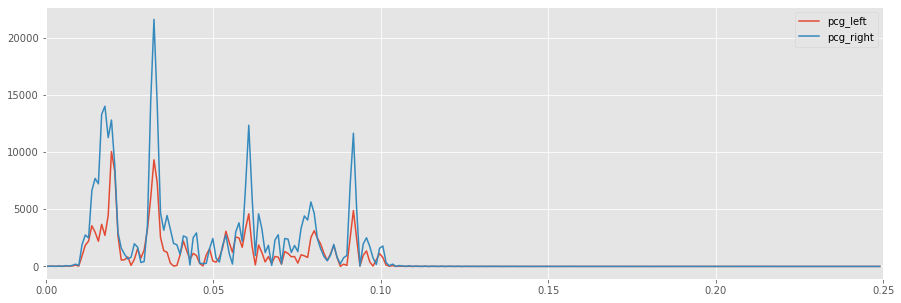

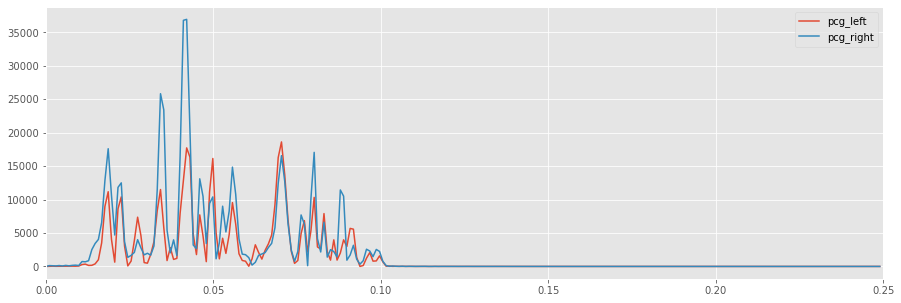

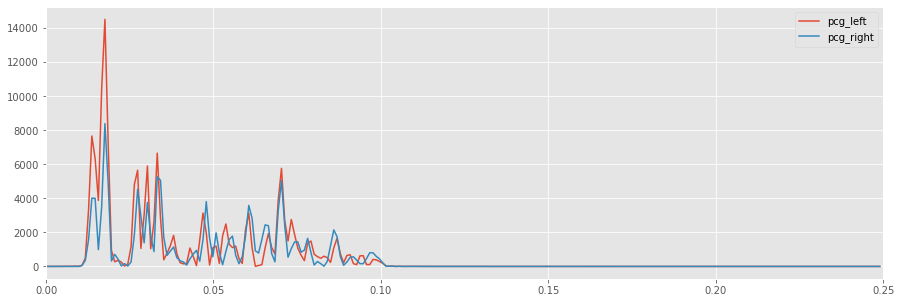

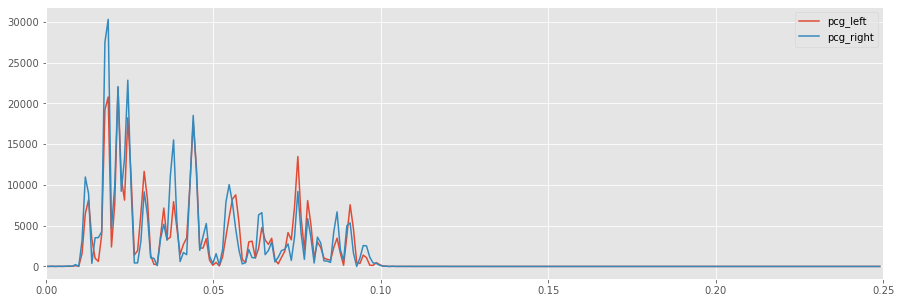

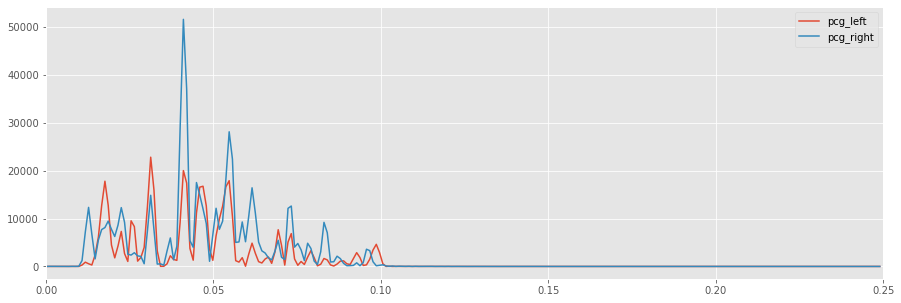

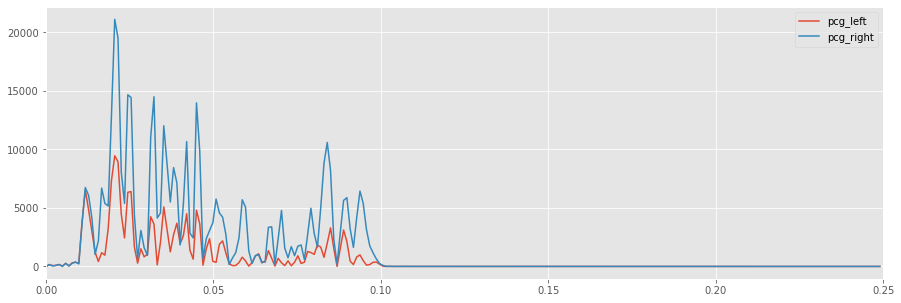

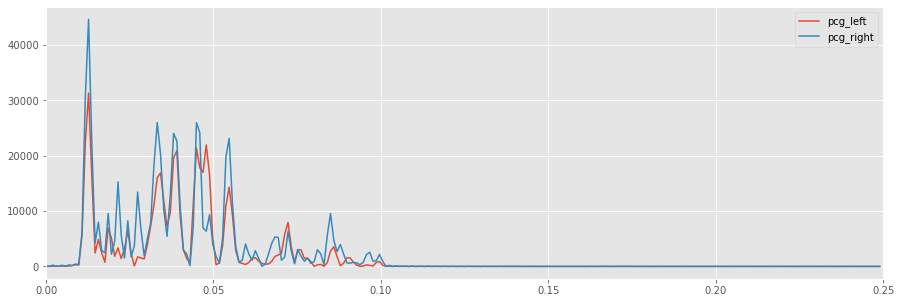

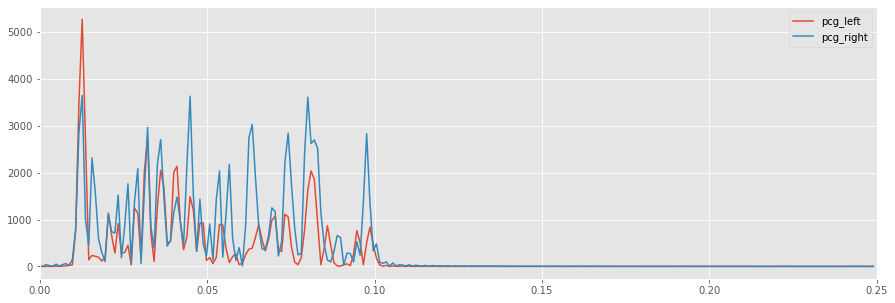

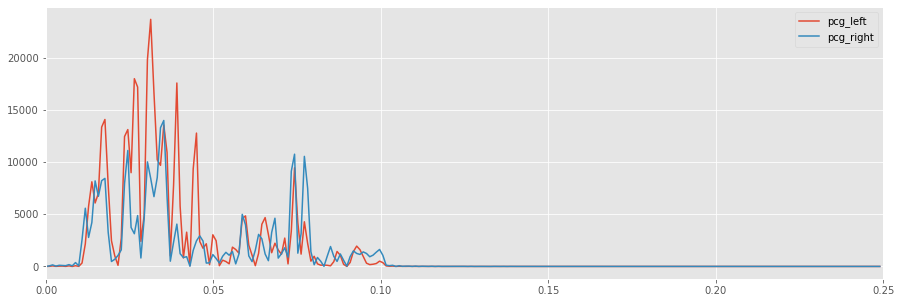

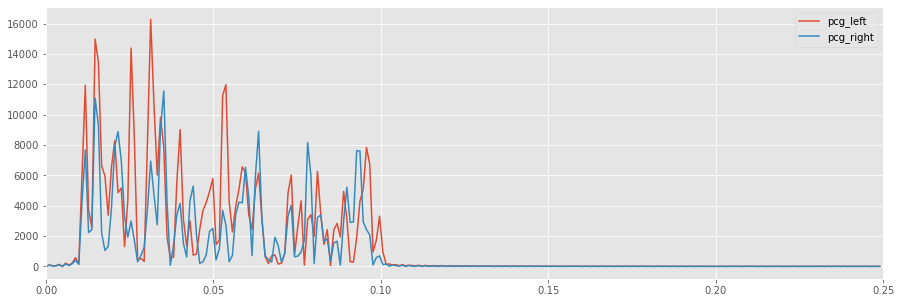

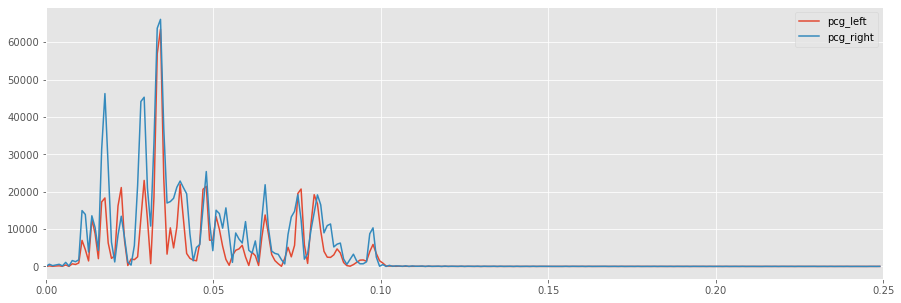

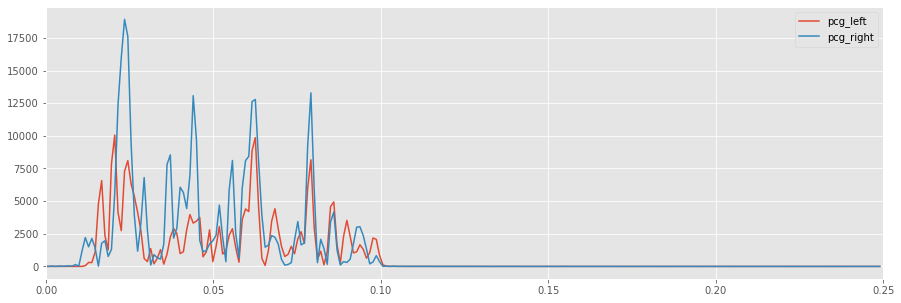

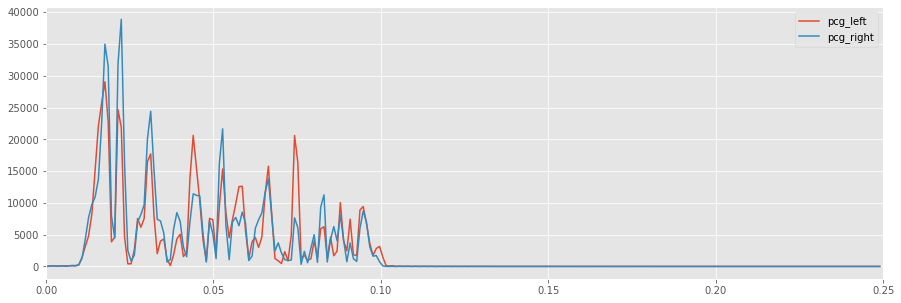

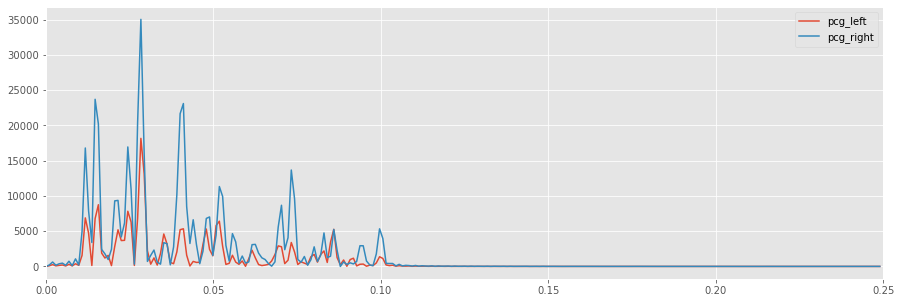

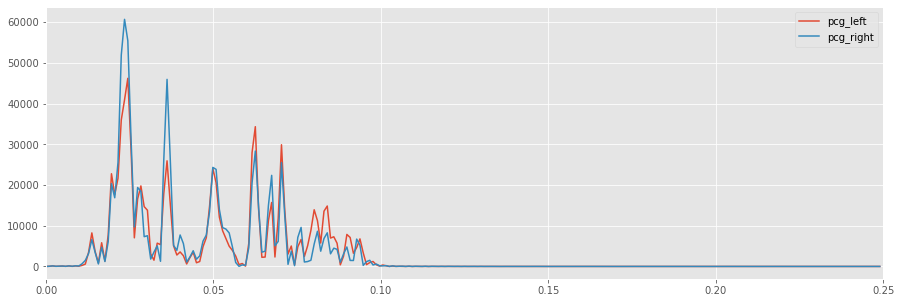

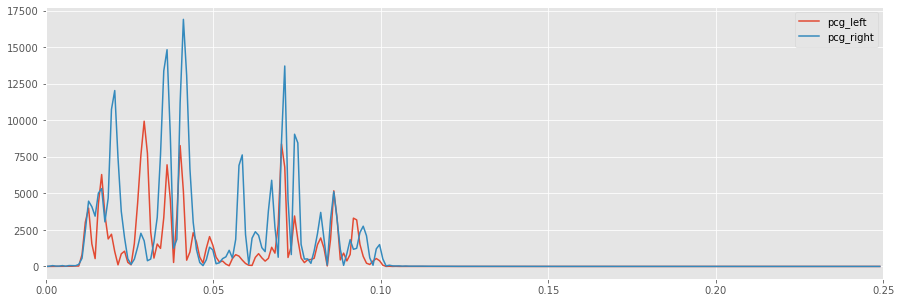

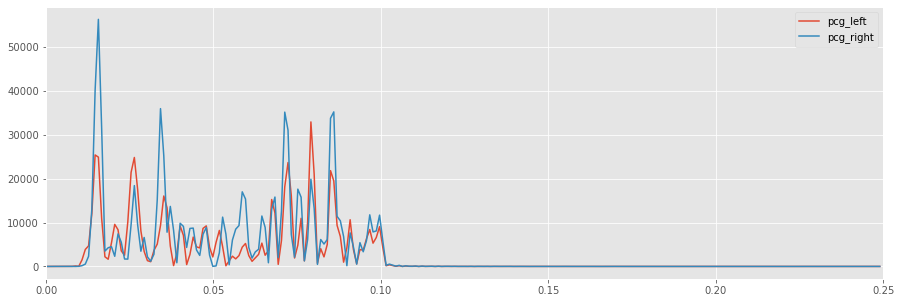

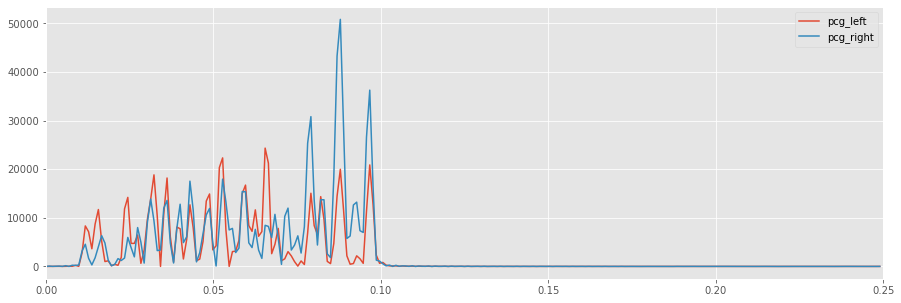

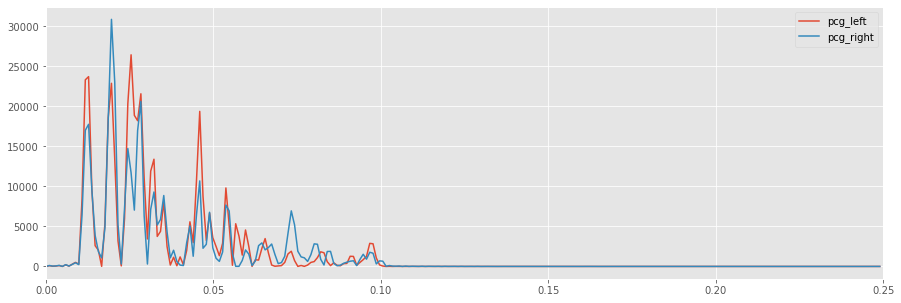

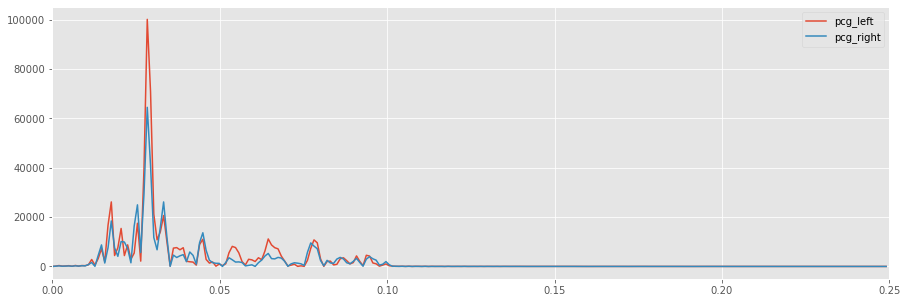

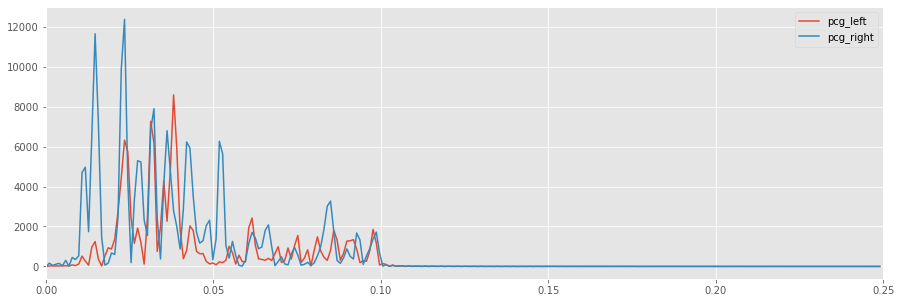

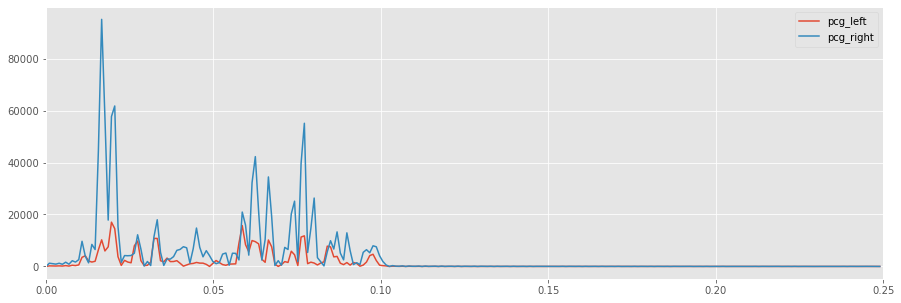

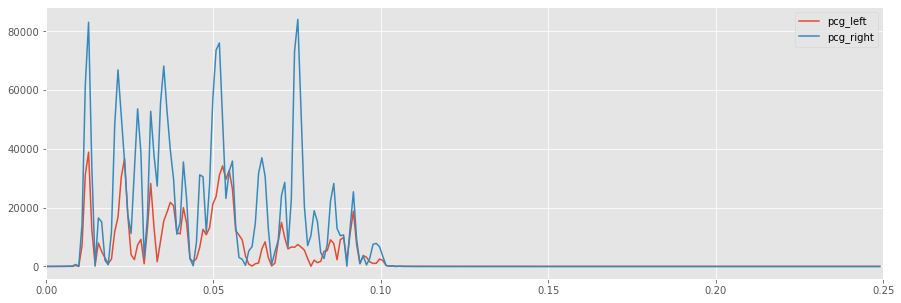

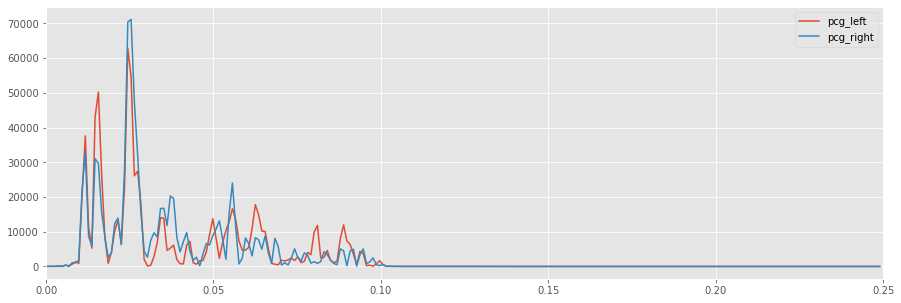

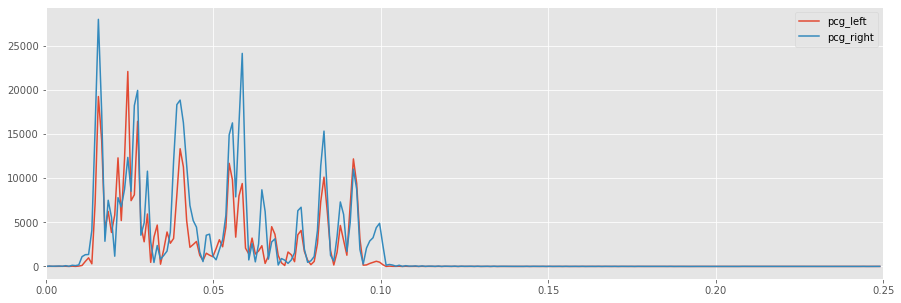

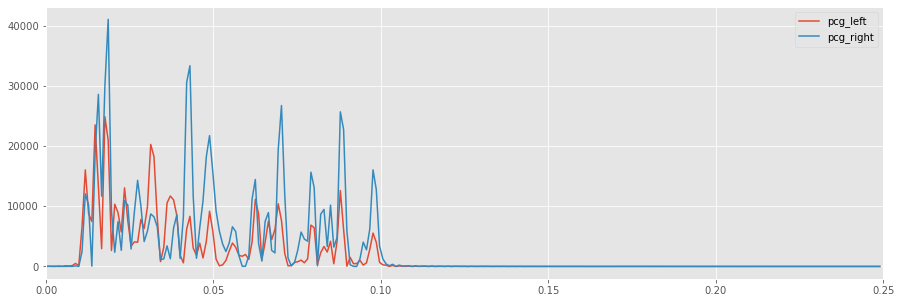

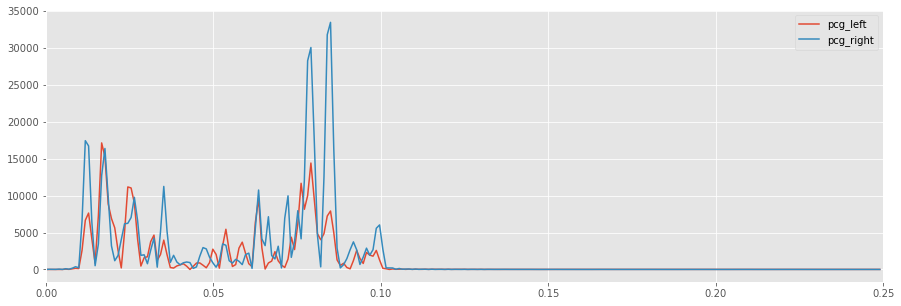

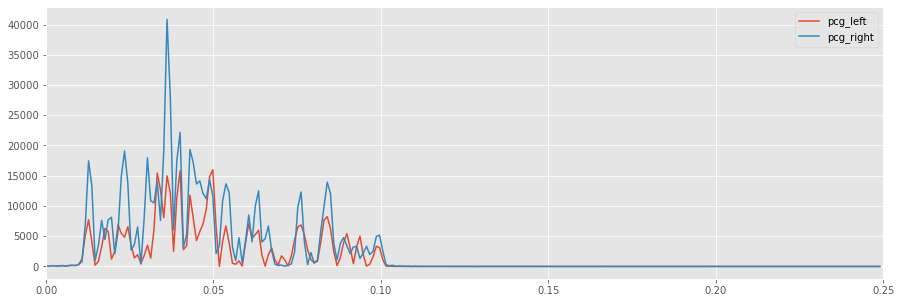

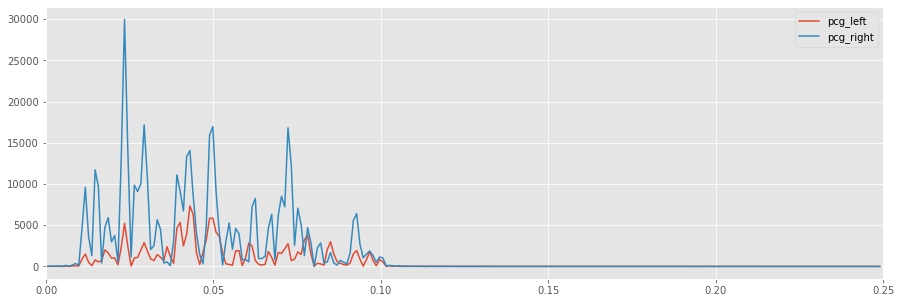

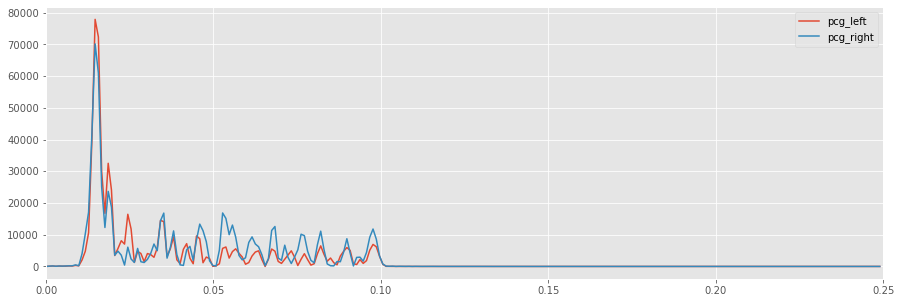

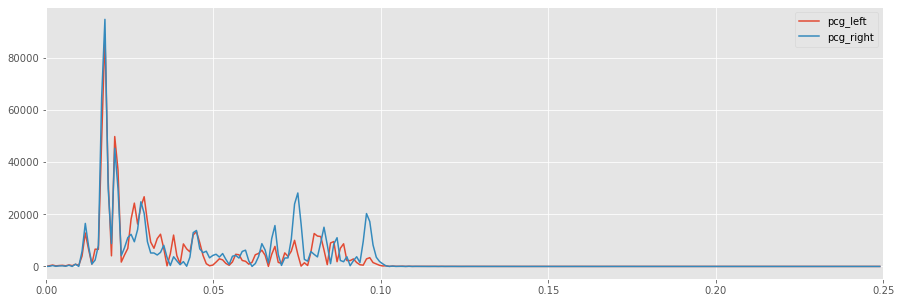

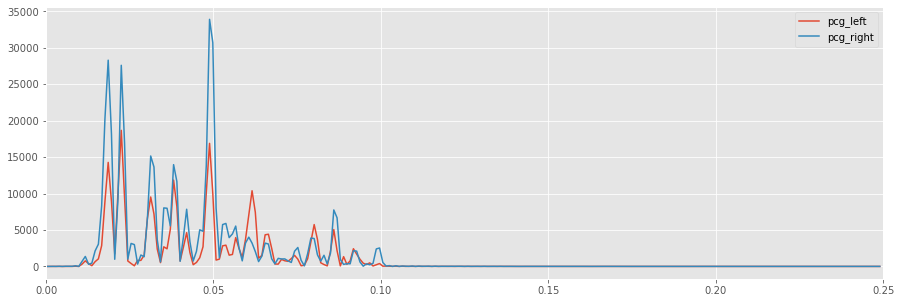

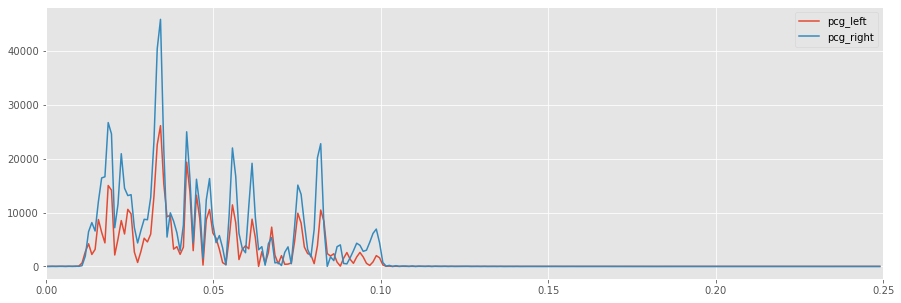

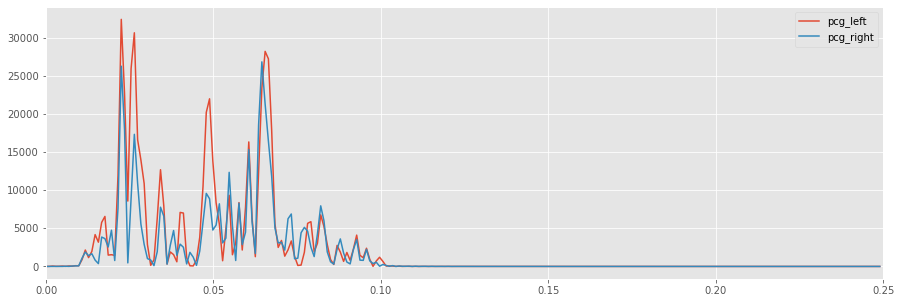

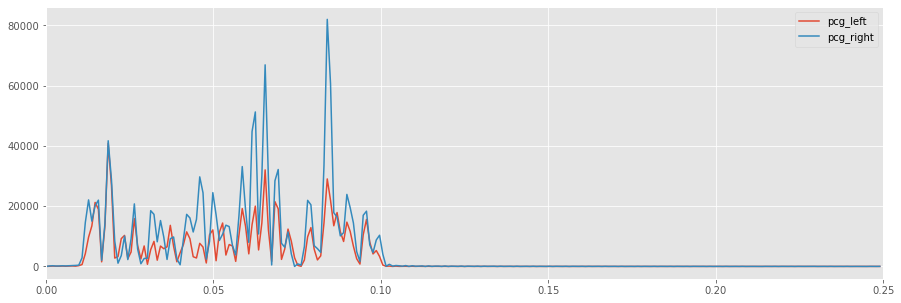

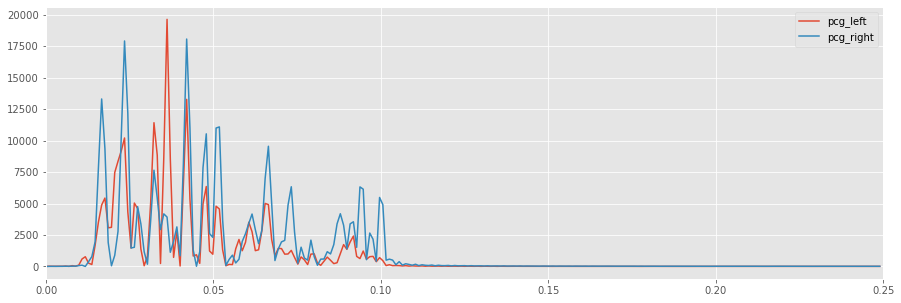

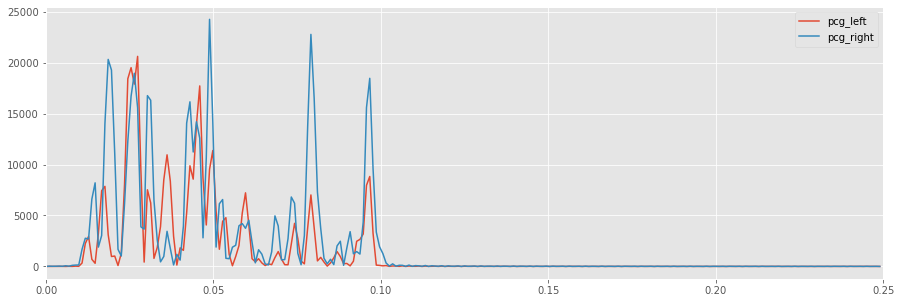

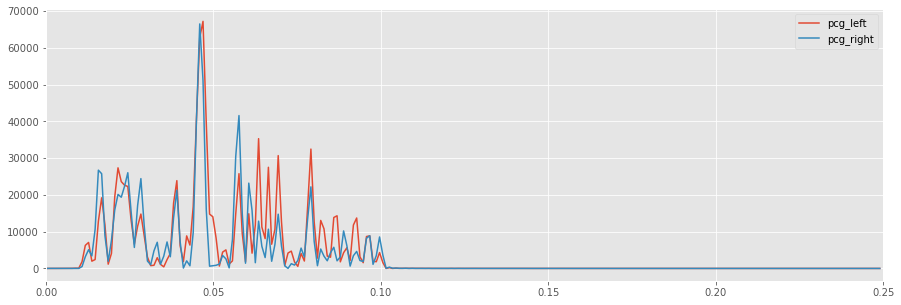

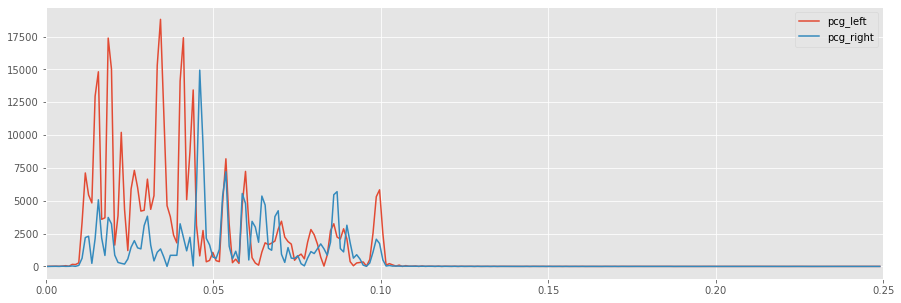

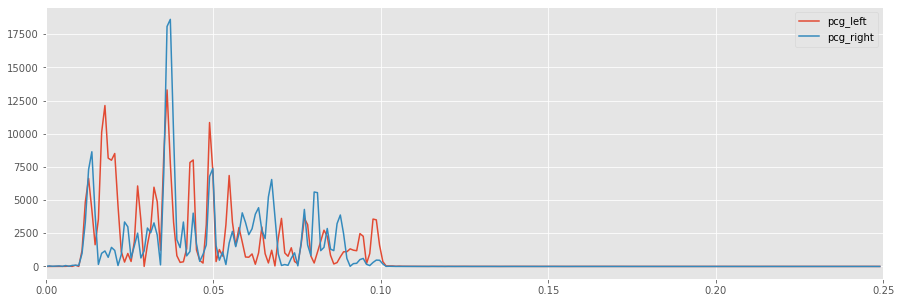

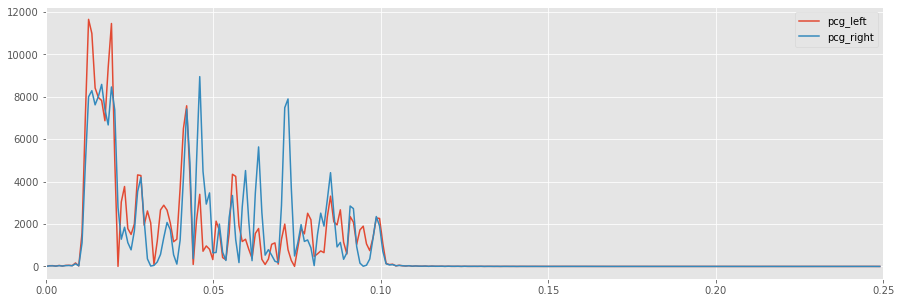

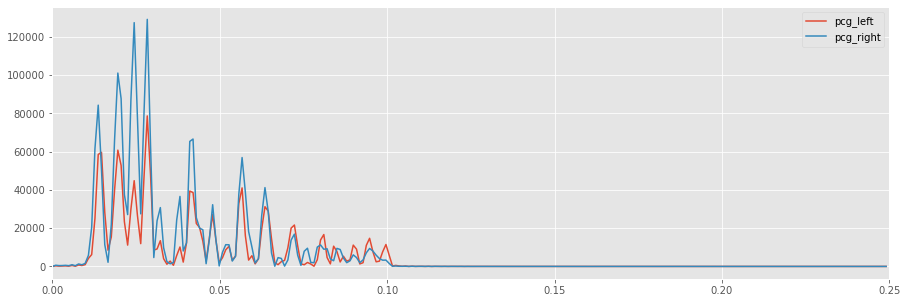

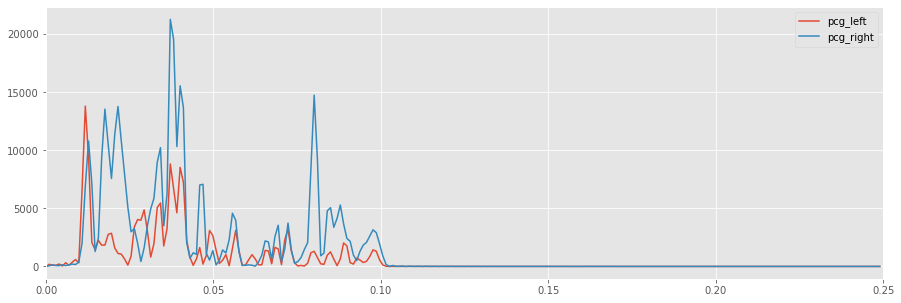

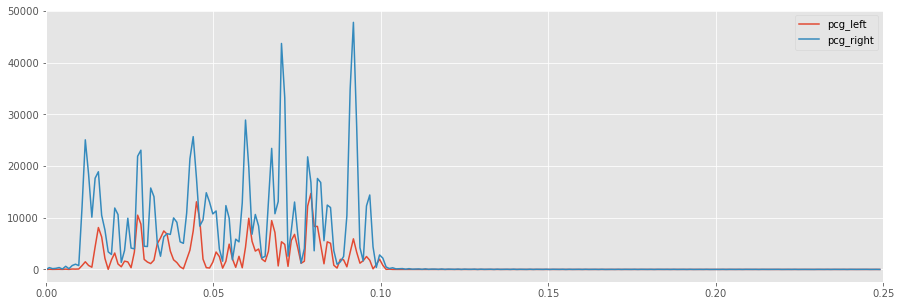

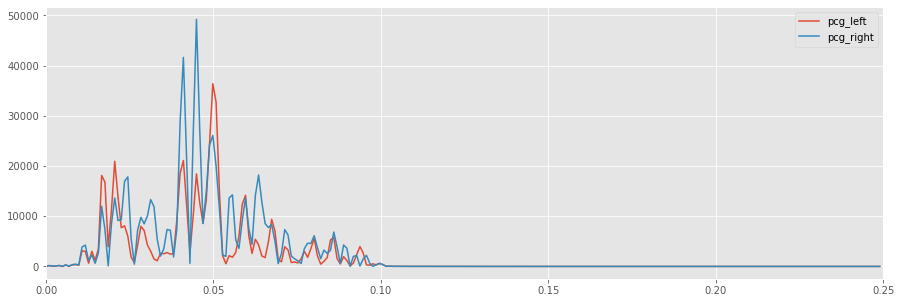

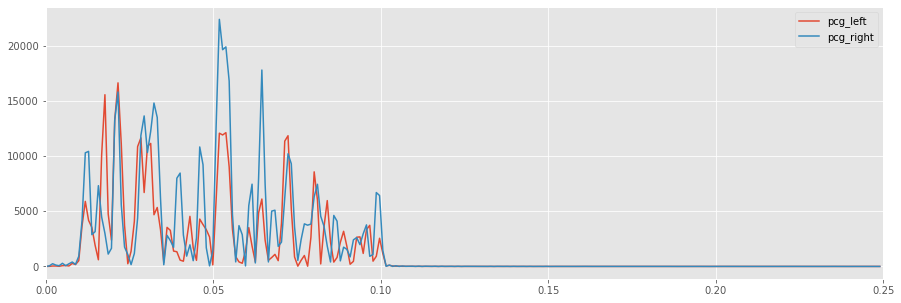

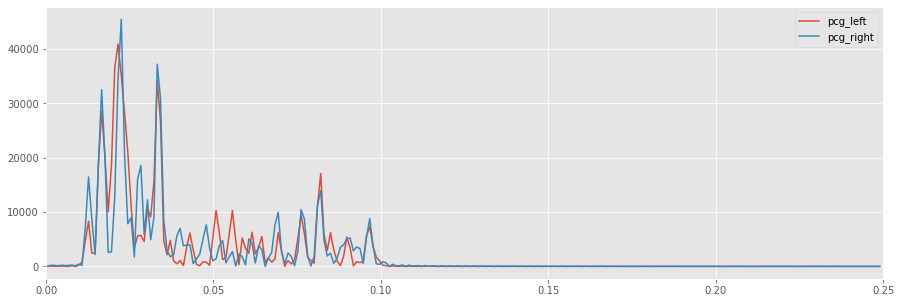

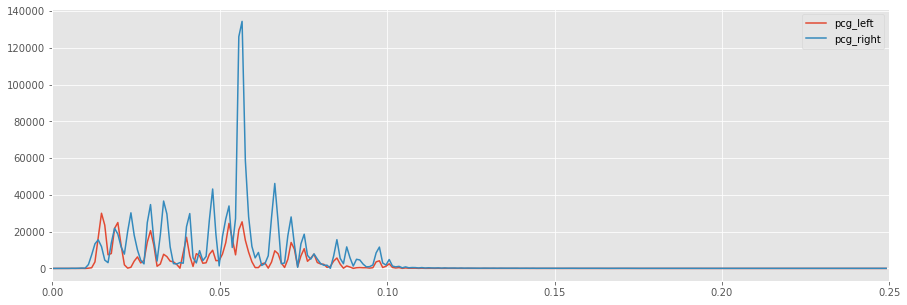

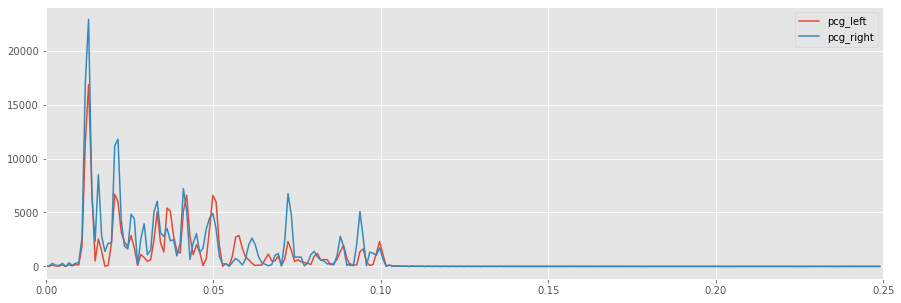

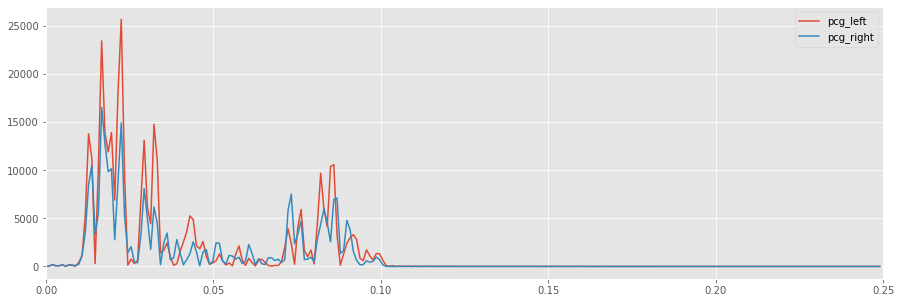

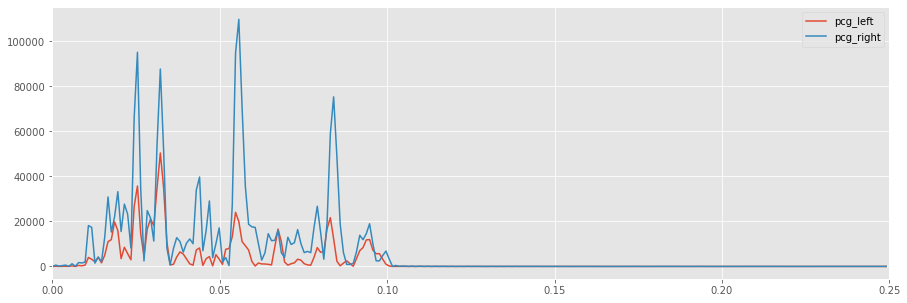

In [3]:
# %matplotlib widget
# bold_psd("SNC","4481A")

df = pd.DataFrame()
for grp, caseid in zip(coData.groups,coData.index):
    x,y = bold_psd(grp,caseid)
    df = pd.concat([df, pd.DataFrame.from_records([{'grp':grp, "casied":caseid, "dominant_left":x, "dominant_right":y}])], ignore_index=True)
df.to_excel('/mnt/c/Users/Wayne/tvb/psdres/dominant_power.xlsx')

In [4]:
# %matplotlib widget
# x = [10,120,130,120,120,100,123,456,78,89]

# subject= SignalToolkit()
# x = x-np.mean(x)
# subject.psd(data=x, sampling_interval=1/10, visual=True, xlim=5, fNQ = 512)